In [88]:
from gurobipy import *
from prettytable import PrettyTable
from numpy import array, concatenate,append

EC = Model('Multi Economic Dispatch')
Gen = ['Gen1','Gen2', 'Gen3', 'Gen4', 'Gen5']
GenAt = {Gen[0]:{'a':3 ,'b':20 ,'c':100, 'd':2 ,'e':-5 ,'f':3 , 'Pmin':28 ,'Pmax':206 },
      Gen[1]:{'a':4.05 ,'b':18.07 ,'c':98.87 , 'd':3.82 ,'e':-4.24 ,'f':6.09 , 'Pmin':90 ,'Pmax':284 },
      Gen[2]:{'a':4.05 ,'b':15.55 ,'c':104.26 , 'd':5.01 ,'e':-2.15 ,'f':5.69 ,'Pmin':68 ,'Pmax':189 },
      Gen[3]:{'a':3.99 ,'b':19.21 ,'c':107.21 , 'd':1.1 ,'e':-3.99 ,'f':6.2 ,'Pmin':76 ,'Pmax':266 },  
      Gen[4]:{'a':3.88 ,'b':26.18 ,'c':95.31 , 'd':3.55 ,'e':-6.88 ,'f':5.57 ,'Pmin':19 ,'Pmax':53 }  }

Iter =40
Load=400
TotalLoad=[]
Objective=[]
Var=[]
CostPeriod = []
EmissionPeriod = []

P = EC.addVars(Gen,lb = [GenAt[i]['Pmin'] for i in Gen], ub = [GenAt[i]['Pmax'] for i in Gen],name = 'Power')
GenTotal = quicksum(P[i] for i in Gen)
GenCost = quicksum(GenAt[i]['c']+GenAt[i]['b']*P[i]+GenAt[i]['a']*P[i]*P[i] for i in Gen)
GenEmissions = quicksum(GenAt[i]['f']+GenAt[i]['e']*P[i]+GenAt[i]['d']*P[i]*P[i] for i in Gen)

#Constraint
target = EC.addConstr( GenTotal == Load, name = 'DemandConst')

EC.setObjective(GenCost, GRB.MINIMIZE)

EC.Params.Method=-1
EC.setParam( 'OutputFlag', False )
EC.optimize()
CostMin = GenCost.getValue()
EmissionMax = GenEmissions.getValue()


EC.setObjective(GenEmissions, GRB.MINIMIZE)

EC.Params.Method=-1
EC.setParam( 'OutputFlag', False )
EC.optimize()
CostMax = GenCost.getValue()
EmissionMin = GenEmissions.getValue()


Results = PrettyTable(['Min Objective','Cost (€)','Emissions (kg)'])
Results.add_row(['Cost', round(CostMin,2), round(EmissionMax,2)])
Results.add_row(['Emissions', round(CostMax,2), round(EmissionMin,2)])                 
print(Results)




for c in range(Iter):
    ELim = (EmissionMin) + ((c)/(Iter-1))*(EmissionMax - EmissionMin)
    
    P = EC.addVars(Gen,lb = [GenAt[i]['Pmin'] for i in Gen], ub = [GenAt[i]['Pmax'] for i in Gen],name = 'Power')
    GenTotal = quicksum(P[i] for i in Gen)
    GenCost = quicksum(GenAt[i]['c']+GenAt[i]['b']*P[i]+GenAt[i]['a']*P[i]*P[i] for i in Gen)
    GenEmissions = quicksum(GenAt[i]['f']+GenAt[i]['e']*P[i]+GenAt[i]['d']*P[i]*P[i] for i in Gen)

    #Constraint
    target = EC.addConstr( GenTotal == Load, name = 'DemandConst')
    
    
    
    
    #Constraint    
    EmissionConstr = EC.addConstr( GenEmissions <= ELim, name = 'EmissionConstr')
    EC.setObjective(GenCost, GRB.MINIMIZE)

    EC.Params.Method=-1
    EC.setParam( 'OutputFlag', False )
    EC.optimize()
    
    CostMinI = GenCost.getValue()
    EmissionMinI = GenEmissions.getValue()
    CostPeriod.append(CostMinI)
    EmissionPeriod.append(EmissionMinI)
    

Parameter Method unchanged
   Value: -1  Min: -1  Max: 5  Default: -1
+---------------+-----------+----------------+
| Min Objective |  Cost (€) | Emissions (kg) |
+---------------+-----------+----------------+
|      Cost     |  131455.0 |    96450.75    |
|   Emissions   | 148684.73 |    87089.4     |
+---------------+-----------+----------------+


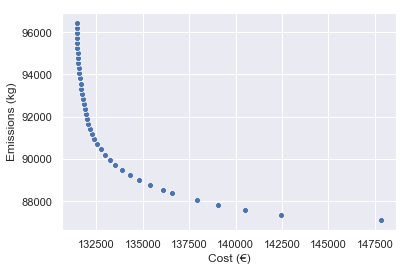

In [89]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from pandas import DataFrame
CP = array(CostPeriod, ndmin =2 )
EP = array(EmissionPeriod, ndmin = 2)
d = concatenate([CP, EP], axis = 0)
df = DataFrame(d.T, columns = ['Cost (€)', 'Emissions (kg)'])
sns.scatterplot(x='Cost (€)' , y = 'Emissions (kg)', data = df)